In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Step 1: Load Up the Data
checking out the first few rows to understand what kind of information we have.

In [2]:
df = pd.read_csv('data/Blood_samples_dataset_balanced_2(f).csv')
encoder = LabelEncoder()
df['Disease'] = encoder.fit_transform(df['Disease'])

# Step 2: Clean the Data

In [3]:
df.fillna(df.mean(), inplace=True)

# Step 3: Mix Up the Data (Feature Extraction)
We’ll use PCA (it’s like a blender for our data)
to mix all the different blood tests into new super-tests that might give us better clues.

In [4]:
X = df.drop('Disease', axis=1)
y = df['Disease']

Standardize our gems so they're all the same size

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Blend them into 10 super-gems

In [6]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Pick the Best Clues (Feature Selection)
After we've got our super-tests, we'll pick the best ones.
These are the clues that really help us figure out the mystery of the disease.

In [7]:
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(X_pca, y)
best_features = selector.get_support(indices=True)

# Step 5: Show What We Found (Visualization)
We’ll make some awesome graphs to show off the best clues we found.
It's like drawing a map that shows where the 'X' marks the spot for our disease treasure.

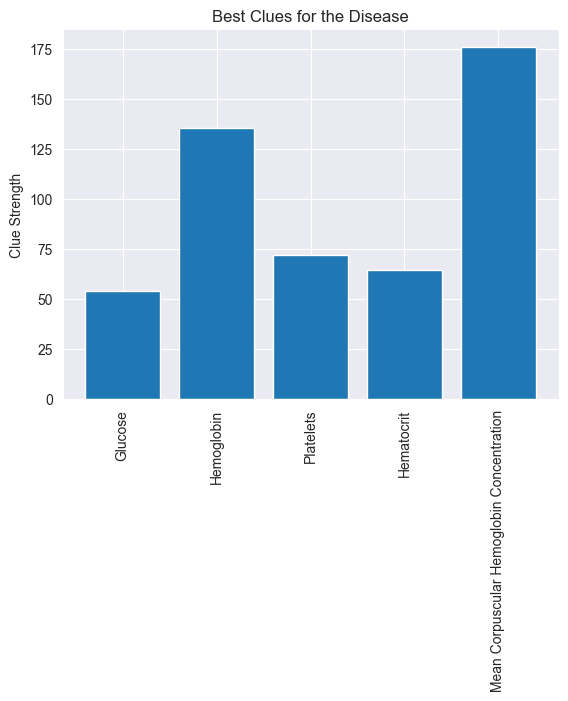

In [8]:
scores = selector.scores_
plt.bar(range(len(best_features)), scores[best_features])
plt.xticks(range(len(best_features)), df.columns[best_features], rotation=90)
plt.title('Best Clues for the Disease')
plt.ylabel('Clue Strength')
plt.show()

Let's use the cleaned and encoded data from before
First, we'll split our data into a training set and a testing set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

Now let's set up our Logistic Regression model
We're going to try different settings to see which one works best (that's the 'optimal setting')

In [10]:
logreg = LogisticRegression()

We'll make a dictionary of all the settings we want to try
'C' is the inverse of regularization strength. smaller values specify stronger regularization
'solver' is the algorithm to use for optimization

In [11]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken to converge
}

This is like a little robot that's going to try all the settings for us (GridSearchCV)
It's going to run logistic regression with each setting, and see which one gets the best 'score'

In [12]:
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

Printing which settings were the best

In [13]:
best_parameters = grid_search.best_params_
print(f"Best Parameters: {best_parameters}")

Best Parameters: {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg'}


Now let's use the best settings to make a new Logistic Regression model

In [14]:
best_logreg = LogisticRegression(C=best_parameters['C'], solver=best_parameters['solver'], max_iter=best_parameters['max_iter'])

We'll train it with our training data

In [15]:
best_logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='newton-cg')

And now, let's see how well it does on the test data

In [16]:
y_pred = best_logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy}")

Accuracy on test data: 0.6348195329087049


Set up our Logistic Regression model with the best settings we found

In [17]:
logreg = LogisticRegression(C=0.1, max_iter=100, solver='liblinear')

Do the 10-fold cross-validation
'cv=10' means we're using 10 folds

In [18]:
scores = cross_val_score(logreg, X_pca, y, cv=10)

Calculate the average score

In [19]:
average_score = scores.mean()

Print the average score

In [20]:
print(f"Average cross-validation score: {average_score}")

Average cross-validation score: 0.7137450414713308


This average score tells us how well our model is expected to do on average